# Cloudbutton geospatial use case: 3D fuel mapping for wildfire risk assessment


In [392]:
import datetime
# from sklearn.naive_bayes import GaussianNB
# from sklearn import model_selection
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import scale, StandardScaler
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans
# from shapely.geometry import mapping
from IPython.display import Image
# from IPython.core.display import HTML
# from shapely.geometry import mapping
# import rasterio as rio
# from sklearn.pipeline import Pipeline
# from rasterio.mask import mask
# from rasterio.plot import show
# from rasterio.merge import merge
# from rasterio.plot import show
# from rasterio.plot import show_hist
# from rasterio.windows import Window
# from rasterio.plot import reshape_as_raster
# from rasterio.plot import reshape_as_image
from lithops.storage import Storage
import matplotlib.pyplot as plt
# import geopandas as gpd
import pandas as pd
import numpy as np
import lithops
import pathlib
# import shapely
import shutil
# import pickle
import subprocess
# import concurrent.futures
# import joblib
# import gdal
# import earthpy as ep
# import earthpy.spatial as es
# import time
# import glob
# import ogr
import os
# import io
# import pdal
# import xarray as xr
import json
# from matplotlib.colors import ListedColormap, BoundaryNorm

In [393]:
DIR_TO_EXECT = "" # "20Gb/10Gb/2Gb/1Gb/512Mb/256Mb/128Mb" # 20Gb/10Gb/2Gb/1Gb/512Mb/256Mb/128Mb
DATA_BUCKET = 'objects-geospatial-wildfirerisk-0'
INPUT_DATA_PREFIX = f'data-example/{DIR_TO_EXECT}' # Modified

In [394]:
# !export LITHOPS_CONFIG_FILE = "/home/aitor/Projects/lithops-github/lithops/.lithops_config"
# os.environ['LITHOPS_CONFIG_FILE'] = '/home/aitor/Projects/lithops-github/lithops/.lithops_config'

Experiment parameters


In [395]:
FCC_WINDOW = 3
FCC_BREAKPOINT = 0.01

---
Upload dataset
---


In [396]:
LOCAL_INPUT_DIR = f'./data/{DIR_TO_EXECT}'

In [397]:
storage = Storage()

2022-05-25 01:37:32,060 [DEBUG] lithops.config -- Loading configuration from C:\Users\saral\.lithops\config
2022-05-25 01:37:32,076 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2022-05-25 01:37:32,076 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2022-05-25 01:37:32,076 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.eu-de.cloud-object-storage.appdomain.cloud
2022-05-25 01:37:32,076 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Using access_key and secret_key
2022-05-25 01:37:32,092 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de


In [398]:
bucket_objects = storage.list_keys(bucket=DATA_BUCKET)
for file_name in os.listdir(LOCAL_INPUT_DIR):
    key = os.path.join(INPUT_DATA_PREFIX, file_name)    # Added
    if key not in bucket_objects:   # Changed: if file_name not in bucket_objects:
        with open(os.path.join(LOCAL_INPUT_DIR, file_name), 'rb') as file:
            print(f'Uploading {key}...')
            data = file.read()
            storage.put_object(bucket=DATA_BUCKET, key=key, body=data)
            print('Ok!')
    else:   # Added
        print(f'It is already uploaded: {key}...')   # Added
'''
for file_name in os.listdir(LOCAL_INPUT_DIR):
    if file_name not in bucket_objects:
        key = os.path.join(INPUT_DATA_PREFIX, file_name)
        with open(os.path.join(LOCAL_INPUT_DIR, file_name), 'rb') as file:
            print(f'Uploading {key}...')
            data = file.read()
            storage.put_object(bucket=DATA_BUCKET, key=key, body=data)
            print('Ok!')
# storage.put_object()
'''

It is already uploaded: data-example/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.laz...
It is already uploaded: data-example/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.laz...
It is already uploaded: data-example/PNOA_2017_CLM-CAS_278-4470_ORT-CLA-RGB.laz...
It is already uploaded: data-example/PNOA_2017_CLM-CAS_650-4434_ORT-CLA-RGB.laz...
It is already uploaded: data-example/PNOA_2017_CLM-CAS_742-4404_ORT-CLA-RGB.laz...
It is already uploaded: data-example/PNOA_2017_CLM-CAS_748-4414_ORT-CLA-RGB.laz...


"\nfor file_name in os.listdir(LOCAL_INPUT_DIR):\n    if file_name not in bucket_objects:\n        key = os.path.join(INPUT_DATA_PREFIX, file_name)\n        with open(os.path.join(LOCAL_INPUT_DIR, file_name), 'rb') as file:\n            print(f'Uploading {key}...')\n            data = file.read()\n            storage.put_object(bucket=DATA_BUCKET, key=key, body=data)\n            print('Ok!')\n# storage.put_object()\n"

---
Calculte DEM, DSM and CHM
---


In [399]:
def calculate_models(obj, storage):
    import pdal
    from osgeo import gdal
    from scipy import ndimage

    # Create temporary file paths
    tmp_path_prefix = '/tmp/geo/'
    if os.path.exists(tmp_path_prefix):
        shutil.rmtree(tmp_path_prefix)
    for subpath in ['dsm', 'dem', 'chm', 'aspect', 'slope', 'fcc']:
        os.makedirs(os.path.join(tmp_path_prefix, subpath), exist_ok=True)

    las_tile_filename = pathlib.Path(obj.key).name
    tile_key = pathlib.Path(obj.key).stem

    # Save obj to file
    data = obj.data_stream.read()
    input_file_path = os.path.join(tmp_path_prefix, las_tile_filename)
    with open(input_file_path, 'wb') as file:
        file.write(data)

    # DSM pipeline
    dsm_file_path = os.path.join(tmp_path_prefix, 'dsm', tile_key + '.gtiff')
    dsm_pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": f"{input_file_path}",
                "spatialreference": "EPSG:25830"
            },
            {
                "type": "filters.reprojection",
                "in_srs": "EPSG:25830",
                "out_srs": "EPSG:25830"
            },
            {
                "type": "filters.outlier",
                "method": "radius",
                "radius": 1.0,
                "min_k": 4
            },
            {
                "type": "filters.range",
                # Classification equals 2 (corresponding to noise points in LAS).
                "limits": "Classification![7:7]"
            },
            {
                "type": "filters.range",
                "limits": "returnnumber[1:1]"
            },
            {
                "type": "writers.gdal",
                "gdaldriver": "GTiff",
                "nodata": "-9999",
                "output_type": "max",
                "resolution": 1,
                "filename": f"{dsm_file_path}"
            }
        ]
    }
    dsm_pipeline_json_str = json.dumps(dsm_pipeline_json, indent=4)
    pipeline = pdal.Pipeline(dsm_pipeline_json_str)
    pipeline.validate()
    pipeline.loglevel = 8
    print('Executing DSM pipeline...')
    result = pipeline.execute()
    print(result)

    # DEM pipeline
    dem_file_path = os.path.join(tmp_path_prefix, 'dem', tile_key + '.gtiff')
    dem_pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": f"{input_file_path}",
                "spatialreference": "EPSG:25830"
            },
            {
                "type": "filters.reprojection",
                "in_srs": "EPSG:25830",
                "out_srs": "EPSG:25830"
            },
            {
                "type": "filters.assign",
                "assignment": "Classification[:]=0"
            },
            {
                "type": "filters.elm"
            },
            {
                "type": "filters.outlier",
                "method": "radius",
                "radius": 1.0,
                "min_k": 4
            },
            {

                "type": "filters.smrf",
                "ignore": "Classification[7:7]",
                "slope": 0.2,
                "window": 16,
                "threshold": 0.45,
                "scalar": 1.2
            },
            {
                "type": "filters.range",
                # Classification equals 2 (corresponding to ground in LAS).
                "limits": "Classification[2:2]",
            },
            {
                "type": "writers.gdal",
                "gdaldriver": "GTiff",
                "nodata": "-9999",
                "output_type": "max",
                "resolution": 1,
                "filename": f"{dem_file_path}"
            }
        ]
    }
    dem_pipeline_json_str = json.dumps(dem_pipeline_json, indent=4)
    pipeline = pdal.Pipeline(dem_pipeline_json_str)
    pipeline.validate()  # Check if json options are good
    pipeline.loglevel = 8
    print('Executing DEM pipeline...')
    result = pipeline.execute()
    print(result)

    # calculate CHM
    chm_file_path = os.path.join(tmp_path_prefix, 'chm', tile_key + '.tiff')
    cmd = ['gdal_calc.py', '-A', dem_file_path, '-B', dsm_file_path,
           '--calc="B-A"', '--NoDataValue=0', '--outfile', chm_file_path]
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, close_fds=True)
    stdout, stderr = p.communicate()
    print(stdout, stderr)
    # assert p.returncode == 0

    # calculate aspect
    aspect_file_path = os.path.join(tmp_path_prefix, 'aspect', tile_key + '.tiff')
    cmd = ['gdaldem', 'aspect', dem_file_path, aspect_file_path, '-compute_edges']
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, close_fds=True)
    stdout, stderr = p.communicate()
    print(stdout, stderr)
    # assert p.returncode == 0

    # calculate slope
    slope_file_path = os.path.join(tmp_path_prefix, 'slope', tile_key + '.tiff')
    cmd = ['gdaldem', 'slope', dem_file_path, slope_file_path, '-compute_edges']
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, close_fds=True)
    stdout, stderr = p.communicate()
    print(stdout, stderr)
    # assert p.returncode == 0

    # calculate FCC
    in_ds = gdal.Open(dem_file_path)
    rows = in_ds.RasterYSize
    cols = in_ds.RasterXSize
    in_band = in_ds.GetRasterBand(1)
    data = in_band.ReadAsArray(0, 0, cols, rows).astype(np.float)
    data[data > FCC_BREAKPOINT] = 1
    data[data <= FCC_BREAKPOINT] = 0

    # Computing fraction on the whole raster through a moving window.
    def _compute_fraction(array):
        nveg = np.sum(array == 1)
        total = len(array)
        out = (nveg/total)*100
        return(out)

    TCC = ndimage.generic_filter(data, _compute_fraction, size=FCC_WINDOW)

    gtiff_driver = gdal.GetDriverByName("GTiff")
    fcc_file_path = os.path.join(tmp_path_prefix, 'fcc', tile_key + '.tiff')
    out_ds = gtiff_driver.Create(fcc_file_path, cols, rows, 1, in_band.DataType)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())

    out_band = out_ds.GetRasterBand(1)
    out_band.WriteArray(TCC)
    # out_ds.BuildOverviews("Average", [2, 4, 8, 16, 32])
    out_ds.FlushCache()
    del in_ds, out_ds

    outputs = [dsm_file_path, dem_file_path, chm_file_path,
               aspect_file_path, slope_file_path, fcc_file_path]
    for output_path in outputs:
        if os.path.exists(output_path):
            with open(output_path, 'rb') as output_file:
                data = output_file.read()
                cos_key = output_path.replace(tmp_path_prefix, '')
                storage.put_object(bucket=DATA_BUCKET, key=cos_key, body=data)
        else:
            print(f'Failed to upload {output_path}')

    out = subprocess.check_output(['find', '/tmp/geo/'])
    return out

In [400]:
fexec = lithops.FunctionExecutor(monitoring='rabbitmq')

2022-05-25 01:37:32,561 [INFO] lithops.config -- Lithops v2.6.0
2022-05-25 01:37:32,561 [DEBUG] lithops.config -- Loading configuration from C:\Users\saral\.lithops\config
2022-05-25 01:37:32,561 [DEBUG] lithops.config -- Loading Serverless backend module: ibm_cf
2022-05-25 01:37:32,561 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2022-05-25 01:37:32,561 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2022-05-25 01:37:32,576 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.eu-de.cloud-object-storage.appdomain.cloud
2022-05-25 01:37:32,576 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Using access_key and secret_key
2022-05-25 01:37:32,592 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de
2022-05-25 01:37:32,592 [DEBUG] lithops.serverless.backends.ibm_cf.ibm_cf -- Creating IBM Cloud Functions client
2022-05-25 01:37:32,592 [DEBUG] lithops.serverless.backen

In [401]:
fexec.map(calculate_models, f'cos://{DATA_BUCKET}/{INPUT_DATA_PREFIX}')

2022-05-25 01:37:32,623 [INFO] lithops.invokers -- ExecutorID bca600-21 | JobID M000 - Selected Runtime: sararl27/lithops-ibm_cf-runtime-3.9:0.1 - 2048MB
2022-05-25 01:37:32,623 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-05-25 01:37:32,623 [DEBUG] lithops.job.job -- ExecutorID bca600-21 | JobID M000 - Calling map on partitions from object storage flow
2022-05-25 01:37:32,623 [DEBUG] lithops.job.partitioner -- Parsing input data
2022-05-25 01:37:32,639 [DEBUG] lithops.job.partitioner -- Chunk size and chunk number not set 
2022-05-25 01:37:32,639 [DEBUG] lithops.job.partitioner -- Listing objects in 'ibm_cos://objects-geospatial-wildfirerisk-0/data-example'
2022-05-25 01:37:33,123 [DEBUG] lithops.job.partitioner -- Total objects found: 6
2022-05-25 01:37:33,123 [DEBUG] lithops.job.partitioner -- Creating 1 partitions from object data-example/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.laz (2.6MiB)
2022-05-25 01:37:33,123 [DEBUG] lithops.job.partition

In [402]:
res = fexec.get_result()

2022-05-25 01:37:34,108 [INFO] lithops.wait -- ExecutorID bca600-21 - Getting results from 6 function activations
2022-05-25 01:37:34,186 [DEBUG] lithops.monitor -- ExecutorID bca600-21 - Pending: 6 - Running: 0 - Done: 0
2022-05-25 01:37:36,202 [DEBUG] lithops.monitor -- ExecutorID bca600-21 - Pending: 3 - Running: 3 - Done: 0
2022-05-25 01:37:38,217 [DEBUG] lithops.monitor -- ExecutorID bca600-21 - Pending: 0 - Running: 6 - Done: 0
2022-05-25 01:37:40,232 [DEBUG] lithops.monitor -- ExecutorID bca600-21 - Pending: 0 - Running: 6 - Done: 0
2022-05-25 01:37:42,247 [DEBUG] lithops.monitor -- ExecutorID bca600-21 - Pending: 0 - Running: 6 - Done: 0
2022-05-25 01:37:44,255 [DEBUG] lithops.monitor -- ExecutorID bca600-21 - Pending: 0 - Running: 6 - Done: 0
2022-05-25 01:37:45,989 [DEBUG] lithops.future -- ExecutorID bca600-21 | JobID M000 - Got status from call 00003 - Activation ID: 3a92d2ab6dd348ad92d2ab6dd318ada3 - Time: 10.89 seconds
2022-05-25 01:37:46,065 [DEBUG] lithops.future -- Exe

In [403]:
res

[b'/tmp/geo/\n/tmp/geo/chm\n/tmp/geo/chm/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff\n/tmp/geo/dsm\n/tmp/geo/dsm/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.gtiff\n/tmp/geo/aspect\n/tmp/geo/aspect/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff\n/tmp/geo/slope\n/tmp/geo/slope/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff\n/tmp/geo/dem\n/tmp/geo/dem/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.gtiff\n/tmp/geo/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.laz\n/tmp/geo/fcc\n/tmp/geo/fcc/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff\n',
 b'/tmp/geo/\n/tmp/geo/fcc\n/tmp/geo/fcc/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff\n/tmp/geo/aspect\n/tmp/geo/aspect/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff\n/tmp/geo/slope\n/tmp/geo/slope/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff\n/tmp/geo/dem\n/tmp/geo/dem/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.gtiff\n/tmp/geo/chm\n/tmp/geo/chm/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff\n/tmp/geo/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.laz\n/tmp/geo/dsm\n/tmp/geo/dsm/PNOA_2017_CLM-CAS_274

In [404]:
for r in res:
    print(r.decode('utf-8').strip())
    print('---')

/tmp/geo/
/tmp/geo/chm
/tmp/geo/chm/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff
/tmp/geo/dsm
/tmp/geo/dsm/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.gtiff
/tmp/geo/aspect
/tmp/geo/aspect/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff
/tmp/geo/slope
/tmp/geo/slope/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff
/tmp/geo/dem
/tmp/geo/dem/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.gtiff
/tmp/geo/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.laz
/tmp/geo/fcc
/tmp/geo/fcc/PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tiff
---
/tmp/geo/
/tmp/geo/fcc
/tmp/geo/fcc/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff
/tmp/geo/aspect
/tmp/geo/aspect/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff
/tmp/geo/slope
/tmp/geo/slope/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff
/tmp/geo/dem
/tmp/geo/dem/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.gtiff
/tmp/geo/chm
/tmp/geo/chm/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.tiff
/tmp/geo/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.laz
/tmp/geo/dsm
/tmp/geo/dsm/PNOA_2017_CLM-CAS_274-4464_ORT-CLA-RGB.gtiff
---
/tmp

---
Scalability
---

#### Time

In [405]:
# fexec.futures

In [406]:
fexec.plot(dst="plotS/scalability")

2022-05-25 01:39:43,986 [INFO] lithops.executors -- ExecutorID bca600-21 - Creating execution plots


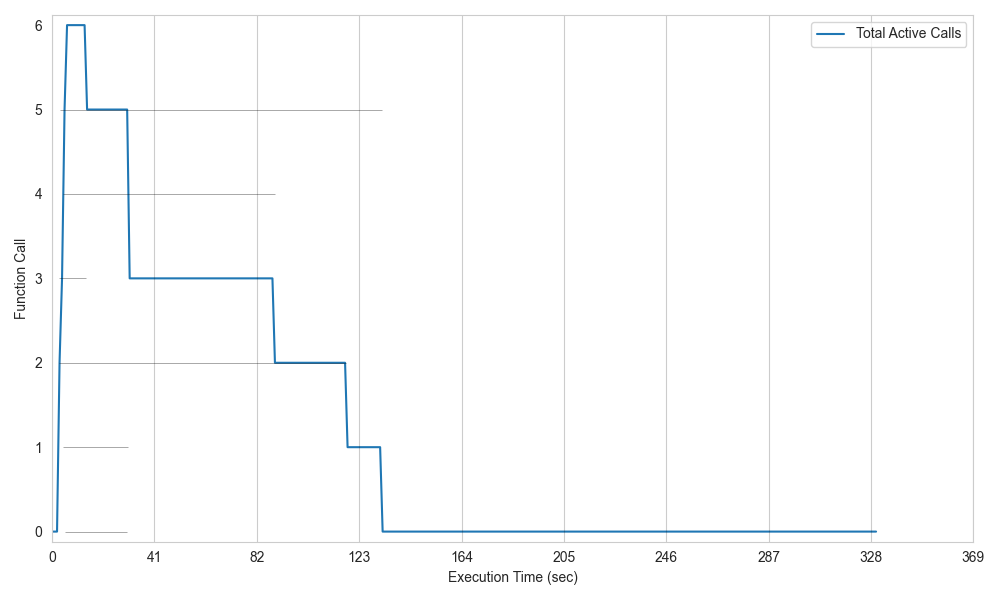

In [407]:
Image(filename="plots/scalability_histogram.png")

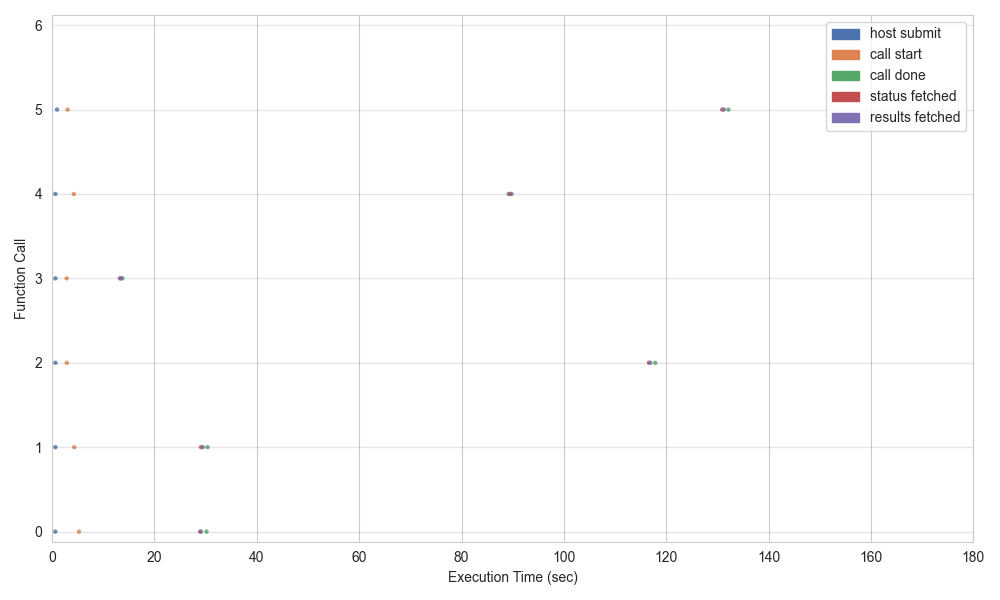

In [408]:
Image(filename="plots/scalability_timeline.png")

#### Throughput

In [409]:
data_size = sum(obj['Size'] for obj in storage.list_objects(DATA_BUCKET) if str(obj['Key']).endswith('.tiff'))
print(f"Data size: {data_size / 1024**2} MiB")

Data size: 301.35498046875 MiB


In [410]:
tstamps = set()
for future in fexec.futures:
    for key in future.stats.keys():
        if key.endswith("tstamp"):
            tstamps.add(future.stats[key])

duration = max(tstamps) - min(tstamps)
print("Duration: " + str(datetime.timedelta(seconds=duration)))

Duration: 0:02:12.135235


In [411]:
throughput = data_size / duration  # Bytes/second

In [412]:
print(f"Throughput: {throughput / 1024**2} MiB/s")

Throughput: 2.280655721864475 MiB/s


#### Cost

In [413]:
def get_process_cost(fexec):
    import pandas as pd
    df = pd.read_csv(fexec.log_path)
    cost = float(df[df["Job_ID"] == "Summary"]["Cost"])
    return cost

In [414]:
fexec.job_summary()

2022-05-25 01:39:44,835 [INFO] lithops.executors -- View log file logs at C:\Users\saral\AppData\Local\Temp\lithops\logs\2022-05-25_01_39_44.csv


In [415]:
pd.read_csv(fexec.log_path)

,Job_ID,Function,Invocations,Memory(MB),AvgRuntime,Cost,CloudObjects
0,M000,calculate_models,6,12288,65.140401,0.013289,
1,Summary,,6,12288,65.140401,0.013289,0


In [ ]:
cost_interpolation = get_process_cost(fexec)
print(f"The experiment cost ${cost_interpolation:.4f}.")

#### Workers (in progress)

In [ ]:
parallel_workers = [2, 4, 8, 16, 32, 64, 128] #2, 4, 8, 16, 32, 64, 128
experiment_duration = dict.fromkeys(parallel_workers)

In [ ]:
'''for workers in parallel_workers:
    print('Workers: ' + str(workers))
    fexec = lithops.FunctionExecutor(

        max_workers=workers, # Tells lithops to work w/only this number of concurrent workers
        log_level="DEBUG"
    )
    fexec.map(calculate_models, f'cos://{DATA_BUCKET}/{INPUT_DATA_PREFIX}')
    fexec.get_result()

    tstamps = set()
    for future in fexec.futures:
        for key in future.stats.keys():
            if key.endswith("tstamp"):
                tstamps.add(future.stats[key])
    duration = max(tstamps) - min(tstamps)
    experiment_duration[workers] = duration'''

2022-05-25 01:44:34,764 [DEBUG] lithops.monitor -- ExecutorID bca600-24 - Pending: 0 - Running: 3 - Done: 3
2022-05-25 01:44:36,922 [DEBUG] lithops.monitor -- ExecutorID bca600-24 - Pending: 0 - Running: 3 - Done: 3
2022-05-25 01:44:39,080 [DEBUG] lithops.monitor -- ExecutorID bca600-24 - Pending: 0 - Running: 3 - Done: 3
2022-05-25 01:44:41,223 [DEBUG] lithops.monitor -- ExecutorID bca600-24 - Pending: 0 - Running: 3 - Done: 3
2022-05-25 01:44:43,370 [DEBUG] lithops.monitor -- ExecutorID bca600-24 - Pending: 0 - Running: 3 - Done: 3
2022-05-25 01:44:45,517 [DEBUG] lithops.monitor -- ExecutorID bca600-24 - Pending: 0 - Running: 3 - Done: 3
2022-05-25 01:44:47,684 [DEBUG] lithops.monitor -- ExecutorID bca600-24 - Pending: 0 - Running: 3 - Done: 3
2022-05-25 01:44:49,823 [DEBUG] lithops.monitor -- ExecutorID bca600-24 - Pending: 0 - Running: 3 - Done: 3
2022-05-25 01:44:51,982 [DEBUG] lithops.monitor -- ExecutorID bca600-24 - Pending: 0 - Running: 3 - Done: 3
2022-05-25 01:44:52,472 [INF

KeyboardInterrupt: 

In [ ]:
# experiment_duration

In [ ]:
'''duration = list(experiment_duration.values())
theoretical_best_speedup = [(1 - parallel_workers[0] / parallel_workers[i]) * 100 for i in range(0, len(parallel_workers))]
actual_speedup = [(1 - duration[i] / duration[0]) * 100 for i in range(0, len(duration))]

plt.plot(
    parallel_workers,
    theoretical_best_speedup
)
plt.plot(
    parallel_workers,
    actual_speedup
)
plt.xlabel("Number of workers")
plt.ylabel("% time reduced, relative to first experiment")
plt.legend(["Ideal speedup", "Lithops speedup (this experiment)"])'''

In [ ]:
# fexec.futures = []     # Clean stats